In [501]:
from operator import attrgetter
import random
from copy import copy, deepcopy
import math
import re
from operator import itemgetter
import matplotlib.pyplot as plt
import time

In [502]:
## Perform Port Placement
seed = random.randrange(100000)
random.seed(seed) #46131
global_t = 1
print("Random Seed", seed)

Random Seed 64777


In [503]:
##
# Length of port is fixed (10)
# Both port_id and block_id are strings
class Port:
    port_width = 10
    def __init__(self, port_id, length, block_id=""):
        self.block_id = block_id
        self.port_id = port_id
        self.length = length
        
    def __deepcopy__(self, memo):
        cls = self.__class__
        obj = cls.__new__(cls)
        memo[id(self)] = obj
        for k, v in self.__dict__.items():
            if k == ['block_id', 'port_id', 'length']:
                v = dict()
            setattr(obj, k, deepcopy(v, memo))
            pass
        return obj

    def get_port_length(self):
        return self.length

    def get_port_block(self):
        return self.block_id
    
    def get_port_id(self):
        return self.port_id
    
    def set_port_id(self, port_id):
        self.port_id = port_id
    
    def set_port_block(self, block_id):
        self.block_id = block_id
        
    def __str__(self):
        return "%s %s %s" % (self.block_id, self.port_id, self.length)
    
    def get_key(self):
        return "%s %s %s " % (self.block_id, self.port_id, self.length)

In [504]:
class BlockIP:
    def __init__(self, block_id, edge_coords, alpha=1, step_decay=1):
        """
            Every edge will be represented by its length
            Every port will be represented by [p, a,b] where p = port, a = edge number, b = position on that edge
        """
        self.block_id = block_id
        
        self.block_coords = edge_coords
        
        self.edges = []
        
        self.block_ports = []
        
        self.alpha = alpha

        self.step_decay = step_decay

        self.overlap_cost = 0
        
        self.map_port = {}
       
    def __deepcopy__(self, memo):
        cls = self.__class__
        obj = cls.__new__(cls)
        memo[id(self)] = obj
        for k, v in self.__dict__.items():
            if k == ['blocked_id', 'block_coords', 'edges', 'alpha', 'overlap_cost', 'map_port']:
                v = dict()
            setattr(obj, k, deepcopy(v, memo))
            pass
        return obj

    def get_block_coords(self):
        return self.block_edges

    def get_block_id(self):
        return self.block_id
 
    def sort_ports(self):
        self.block_ports.sort(key=itemgetter(1), reverse=False)

    def process_edges(self):
        for index in range(len(self.block_coords)-1):
            x1, y1 = self.block_coords[index]
            x2, y2 = self.block_coords[index+1]
            
            dir = +1
            length = abs(x1-x2) + abs(y1-y2)
            if x1==x2 and y2 <= y1:
                dir = -1
            if y1==y2 and x2 <= x1:
                dir = -1
            
            self.edges.append([length, dir])
    
    def add_port(self, port):
        total_ports = len(self.block_ports)

        # port, edge_number, position_on_edge
        self.map_port[port.get_port_id()]=total_ports
        self.block_ports.append([port,0,0]) #  placing everything on the 0-th edge
        
        # update port's block_id
        self.block_ports[total_ports][0].set_port_block(self.block_id)
    
    def print_ports(self):
        for ports in self.block_ports:
            print('\t',ports[0].get_port_id())
    
    def line_overlaps(self, port1_info, port2_info):
        port1 , edge1, pos1 = port1_info
        port2 , edge2, pos2 = port2_info

        if edge1!=edge2:
            return 0

        if pos2 < pos1:
            # swap
            temp = port1 , edge1, pos1
            port1 , edge1, pos1 = [port2 , edge2, pos2]
            port2 , edge2, pos2 = temp

        len1 = port1.get_port_length()
        len2 = port2.get_port_length()
        overlap = 0
        
        if pos1 + len1 <= pos2:
            overlap = 0
        elif pos1 + len1 >=pos2 and pos2 + len2 >= pos1 + len1:
            overlap = pos1 + len1 - pos2
        elif pos1 + len1 >=pos2 and pos2 + len2 <= pos1 + len1:
            overlap = len2
        return overlap
    
    ## overlap is a property of a block (independent of other blocks)
    def edge_overlap(self, edge_id):
        curr_len = len(self.block_ports)
        edge_ports = []
        overlap = 0
        for port_info in self.block_ports:
            port , edge, pos = port_info
            if edge == edge_id:
                edge_ports.append(port_info)
        
        for index1 in range(len(edge_ports)):
            for index2 in range(len(edge_ports)):
                if index1==index2:
                    continue
                overlap += self.line_overlaps(edge_ports[index1], edge_ports[index2])
        return overlap/2
                
    def total_overlap(self):
        total_overlap = 0
        for index in range(0, len(self.edges)):
            total_overlap += self.edge_overlap(index)
        
        self.overlap_cost=total_overlap
        return total_overlap
    
    def move_port(self, port_id, direct):
        global global_t
        port, edge, pos = self.block_ports[port_id]
        port_len = port.get_port_length()
        pos += direct*(max(1,int(self.alpha - self.step_decay**global_t)))
        
        edge_len, edge_dir = self.edges[edge]
        new_edge = edge
        new_pos = pos

        moved_to_other_edge=False
        if pos<0:
            # move to previous edge
            moved_to_other_edge=True
            new_edge = edge-1
            if new_edge<0:
                new_edge = len(self.edges)-1
            new_pos = self.edges[new_edge][0] - port_len
        elif pos+port_len>edge_len:
            # move to next edge
            moved_to_other_edge=True
            new_edge=edge+1
            if new_edge>=len(self.edges):
                new_edge = 0
            new_pos = 0
        
        cost = -self.edge_overlap(edge) 
        if moved_to_other_edge==True:
            cost -= self.edge_overlap(new_edge)
        
        self.block_ports[port_id] = [port, new_edge, new_pos]
        
        cost += self.edge_overlap(edge)
        if moved_to_other_edge==True:
            cost += self.edge_overlap(new_edge)
        
        self.overlap_cost += cost

    def get_port_index(self, port_name):
        return self.map_port[port_name]

    def get_port_pos(self, port_name):
        port_index = self.map_port[port_name]
        port, edge, pos = self.block_ports[port_index]
        
        corner_x, corner_y  = self.block_coords[edge]
        _, direct = self.edges[edge]
        
        posx_l = corner_x
        posy_l = corner_y
        posx_r = corner_x
        posy_r = corner_y
        port_len = port.get_port_length()
        if direct == 1 and edge%2==0:
            posy_l += pos
            posx_r += Port.port_width
            posy_r += pos + port_len
        elif direct == 1 and edge%2==1:
            posx_l += pos
            posx_r += pos + port_len
            posy_r -= Port.port_width
        elif direct == -1 and edge%2==0:
            posy_l -= pos
            posx_r -= Port.port_width
            posy_r -= pos + port_len
        else:
            posx_l -= pos
            posx_r -= pos + port_len
            posy_r += Port.port_width
            
        return [posx_l, posy_l, posx_r, posy_r]
            

In [505]:
class state:
    block_list = []
    map_blocks = {}
    map_connectivity = {}
    action_set = []

    def __init__(self, blocks):
        self.blocks = copy(blocks)
        self.visits=0
        self.cost=0.0
        self.children = [] #stores the child nodes
        self.parent = None
        self.unexplored = []
        self.count_child = 0
        self.eps = 30
        self.penalty=0
        self.level=0
        self.init_unexplored()

    @classmethod
    def initialise_class(cls, block_list, map_blocks, map_connectivity, action_set):
        cls.block_list = block_list
        cls.map_blocks = map_blocks
        cls.map_connectivity = map_connectivity
        cls.action_set = action_set
    
    def init_unexplored(self):
        self.unexplored = []
        for index, action in enumerate(state.action_set):
            self.unexplored.append(index)
        
    def add_child(self, child):
        self.children.append(child)
        self.count_child += 1

    def get_key(self):
        key = ""
        for block in self.blocks():
            key += block.get_key()
        return key
    
    def best_child_traverse(self):
        value = -1e12
        pos = 0
        for index, child in enumerate(self.children):
            curr_value = child.get_state_traverse_value()
            if curr_value > value:
                value = curr_value
                pos = index 
        return self.children[pos]

    def best_child(self):
        value = -1e12
        pos = 0
        for index, child in enumerate(self.children):
            curr_value = child.get_state_value()
            if curr_value > value:
                value = curr_value
                pos = index 
        return self.children[pos]
    
    def get_state_traverse_value(self):
        global global_t
        curr_visits = self.visits
        if curr_visits==0:
            curr_visits = 0.0000000001
            return 1e12
        return -(self.cost/curr_visits)

    def get_state_value(self):
        global global_t
        curr_visits = self.visits
        if curr_visits==0:
            curr_visits = 0.0000000001
            return 1e12
        return -(self.cost/curr_visits) + self.eps*(2*math.log(global_t)/curr_visits)**0.5
    
    def visit(self):
        self.visits += 1
        
    def cost_block_port(self, block_name, port_name):
        curr_cost = 0.0
        for con, freq in state.map_connectivity[block_name+'.'+port_name]:
            IP, port2 = con.split(".")
            curr_cost += self.get_dist(state.map_blocks[block_name], state.map_blocks[IP], port_name, port2)
        return curr_cost
        
    # Calcuulate Initial Total Cost    
    def calculate_dist(self):
        self.total_cost = 0.0
        for con1 in state.map_connectivity.keys():
            ip1, port1 = con1.split('.')
            for ip_port in state.map_connectivity[con1]:
                ip2, port2 = ip_port[0].split('.')
                self.total_cost += self.get_dist(state.map_blocks[ip1], state.map_blocks[ip2], port1, port2)
        self.total_cost /= 2.0
        return self.total_cost

    # get Euclidean distance
    def get_dist(self, block1_index, block2_index, port1, port2, is_HPWL=False):
        x1_l, y1_l, x1_r, y1_r = self.blocks[block1_index].get_port_pos(port1)
        x2_l, y2_l, x2_r, y2_r = self.blocks[block2_index].get_port_pos(port2)

        x1 = (x1_l + x1_r)/2.0; y1 = (y1_l + y1_r)/2.0
        x2 = (x2_l + x2_r)/2.0; y2 = (y2_l + y2_r)/2.0
        # HPWL (Half perimeter wire length)
        if is_HPWL:
            dist = abs(x2-x1) + abs(y2-y1)
        else:
            dist = ((x2-x1)**2 + (y2-y1)**2)**0.5
        return dist

    def get_overlap_cost(self):
        overlap_cost = 0
        for block in self.blocks:
            overlap_cost += block.total_overlap()
        return overlap_cost

    def get_total_cost(self):
        # Connection cost
        connection_cost = self.calculate_dist()
        
        # Overlap cost
        overlap_cost = self.get_overlap_cost()
        return connection_cost + self.penalty*overlap_cost
    
    # Generate output
    def export_port_positions(self, file_path="tests/dataset_3_output.csv"):
        f = open(file_path, "w")
        for block in self.blocks:
            for port, edge, pos in block.block_ports:
                port_id = port.get_port_id()
#                 print("block_port", port_id, edge, pos)
#                 print("port_length", port.get_port_length())
                x_l, y_l, x_r, y_r = block.get_port_pos(port_id)
                if max(abs(y_r-y_l),abs(x_l-x_r)) > block.edges[edge][0]:
                    continue
                x_l, y_l, x_r, y_r = str(x_l), str(y_l), str(x_r), str(y_r)
#                 print("loc", x_l, y_l, x_r, y_r)
                f.write(port_id+", "+"{"+x_l+" " + y_l+"} "+"{"+x_l+" "+y_r+"} "+"{"+x_r+" "+y_r+"} "+"{"+x_r+" "+y_l+"}\n")
        f.close()

In [506]:
class MCTS:
    def __init__(self):
        self.root=None
        self.block_list = []
        self.map_blocks = {}
        self.map_connectivity = {}
        self.run_blocks_once = True
        self.run_connectivity_once = True
        self.max_height = 1000
        self.action_set = []
        self.alpha = 10
        self.step_decay = 1.0003

    def set_root(self):
        self.root = state(self.block_list)
        self.root.initialise_class(self.block_list, self.map_blocks, self.map_connectivity, self.action_set)
        self.root.init_unexplored()
        
    def preprocess_blocks(self):
        for block in self.block_list:
            block.process_edges()
        for block in self.block_list:
            for port, edge, pos in block.block_ports:
                self.action_set.append([self.map_blocks[block.get_block_id()], port.get_port_id(), +1])
                self.action_set.append([self.map_blocks[block.get_block_id()], port.get_port_id(), -1])
            
    # Parse blocks.csv
    def parse_blocks(self, file_path='tests/new_tests/block.csv'):
        if self.run_blocks_once==True:
            self.block_list = []
            self.map_blocks = {}
            index=0
            with open(file_path) as f:
                for lines in f:
                    IP, coords = lines.strip().split(",")
                    coord_list = []
                    for coord in re.findall('{(.+?)}',coords):
                        a,b = coord.split(" ")
                        coord_list.append([int(a),int(b)])

                    if len(coord_list)!=0:
                        curr_block = BlockIP(IP, coord_list, alpha = self.alpha, step_decay = self.step_decay)
                        self.block_list.append(curr_block)
                        self.map_blocks[IP]=index
                        index+=1
            self.run_blocks_once=False
            
    # Parse connectivity.csv
    def parse_ports(self, file_path='tests/new_tests/con.csv'):
        IP_port_pair = {}
        if self.run_connectivity_once==True:
            self.run_connectivity_once=False
            self.map_connectivity = {}
            index=0
            with open(file_path) as f:
                for lines in f:
                    row = lines.strip().split(", ")
                    if len(row)==4:
                        con1, con2, length, freq = row
                        IP1, port1 = con1.split(".")
                        IP2, port2 = con2.split(".")

                        if con1 not in IP_port_pair.keys():
                            port_obj1 = Port(port1, int(length))
                            self.block_list[self.map_blocks[IP1]].add_port(port_obj1)
                            IP_port_pair[con1]=1

                        if con2 not in IP_port_pair.keys():
                            port_obj2 = Port(port2, int(length))
                            self.block_list[self.map_blocks[IP2]].add_port(port_obj2)
                            IP_port_pair[con2]=1

                        if con1 in self.map_connectivity.keys():
                            self.map_connectivity[con1].append([con2, int(freq)])
                        else:
                            self.map_connectivity[con1] = [[con2, int(freq)]]

                        if con2 in self.map_connectivity.keys():
                            self.map_connectivity[con2].append([con1, int(freq)])
                        else:
                            self.map_connectivity[con2] = [[con1, int(freq)]]

In [507]:
# class MCTS(MCTS):
#     def simulated_annealing(self, curr_state, temperature=10000):
#         iterations = 1000
#         for iter in range(iterations):
#             curr_cost = curr_state.get_total_cost()
            
#             block_id, port_id, direct = random.choice(self.action_set)        
#             curr_state.blocks[block_id].move_port(curr_state.blocks[block_id].get_port_index(port_id), direct)
            
#             new_cost = curr_state.get_total_cost()
#             delta = new_cost - curr_cost
            
#             if delta>0:
#                 p = math.exp(-delta*iter/temperature)
#                 if p<0.5:
#                     # undo
#                     curr_state.blocks[block_id].move_port(curr_state.blocks[block_id].get_port_index(port_id), -direct)
# #                 else:
# #                     # accept
# #                     curr_state = next_state
# #             else:
# #                 # accept
#         return curr_state.get_total_cost()

In [508]:
class MCTS(MCTS):
    def simulated_annealing(self, curr_state, temperature=100000, iterations=100000, flag=False): 
        result = []
        for iter in range(iterations):
            #curr_cost = curr_state.get_total_cost()
            
            block_id, port_id, direct = random.choice(self.action_set)        
            curr_block_port_cost = curr_state.cost_block_port(self.block_list[block_id].get_block_id(), port_id)
            curr_block_overlap_cost = curr_state.blocks[block_id].overlap_cost
            
            curr_state.blocks[block_id].move_port(curr_state.blocks[block_id].get_port_index(port_id), direct)

            #new_cost = curr_state.get_total_cost()
            #delta1 = new_cost - curr_cost
            
            next_block_port_cost = curr_state.cost_block_port(self.block_list[block_id].get_block_id(), port_id)
            next_block_overlap_cost = curr_state.blocks[block_id].overlap_cost
            delta = -curr_block_port_cost + next_block_port_cost + (next_block_overlap_cost-curr_block_overlap_cost)*curr_state.penalty
            
            #print(curr_block_port_cost, curr_block_overlap_cost, next_block_port_cost, next_block_overlap_cost)
            
            #print("deltas", delta, delta1)
            if delta>0:
                p = math.exp(-delta*iter/temperature)
                if p<0.5:
                    # undo
                    curr_state.blocks[block_id].move_port(curr_state.blocks[block_id].get_port_index(port_id), -direct)
#                 else:
#                     # accept
#                     curr_state = next_state
#             else:
#                 # accept
            if flag:
                result.append(curr_state.get_total_cost())
        if flag:
            plt.plot(result)
        return curr_state.get_total_cost()

In [509]:
class MCTS(MCTS):
    def expand(self, curr_state):
        #print('here1 level', curr_state.level,"\n", len(curr_state.children))
        count = len(curr_state.children)
        block_id, port_id, direct = self.action_set[count]
        child = copy(curr_state)
        
        child.parent = curr_state
        child.children = []
        child.blocks = deepcopy(curr_state.blocks)
        #child.level = copy(curr_state.level)
        #child.init_unexplored()
        
        child.blocks[block_id].move_port(child.blocks[block_id].get_port_index(port_id), direct)
        child.level += 1
        curr_state.children.append(child)
#         print("parent level", curr_state.level)
#         print("child level", child.level)
#         print("parent children", len(curr_state.children))
#         print("child children", len(child.children))
        return child

    def tree_policy(self, curr_state):
#         print("start")
        level = 1
        for i in range(0, self.max_height):
#             print('here2 level', curr_state.level," children: ", len(curr_state.children))
            if len(curr_state.children) != len(self.action_set):
                return [self.expand(curr_state), level]
            else:
                curr_state = curr_state.best_child()
                level += 1
#         print("end")
        return [curr_state, level]
    
    def default_policy(self, curr_state):
        next_state = deepcopy(curr_state)
        level=1
        for index in range(next_state.level, next_state.level+100):
            count = len(next_state.children)
            #print('here2 level', next_state.level,"\n", len(next_state.children))
            rand_index = random.choice(range(0, len(self.action_set)))
            block_id, port_id, direct = self.action_set[rand_index]
            
            #child.init_unexplored()
            next_state.blocks[block_id].c(next_state.blocks[block_id].get_port_index(port_id), direct)
            level += 1
        return [next_state.get_total_cost(), level]
        
    def backup(self, curr_node, cost):
        while(curr_node.level!=0):
#             print("level", curr_node.level)
            curr_node.visit()
            curr_node.cost += cost
            curr_node = curr_node.parent
        
    def traverse_final(self, curr_state):
        while(len(curr_state.children)!=0):
            curr_state = curr_state.best_child_traverse()
        return curr_state
        
    def perform_MCTS(self, root):
        global global_t
        outputs = []
        for i in range(1000):
            s, level = self.tree_policy(root)
            print("iter", i, " level", level, "\n")
            #cost = self.default_policy(s)
            cost = self.simulated_annealing(s, iterations=level*1000, temperature=level*1000)
            outputs.append(cost)
            print("winner", cost)
            self.backup(s, cost)
            global_t += 1
        return outputs

In [510]:
obj = MCTS()

obj.parse_blocks('tests/new_tests/block_4X.csv')
obj.parse_ports('tests/new_tests/con_4X.csv')
obj.preprocess_blocks()
obj.set_root()

#print(obj.root.unexplored)
# for block in obj.block_list:
#     print(block.get_block_id())
#     #block.print_ports()
#     print("edge_overlap before", block.edge_overlap(0))
#     block.move_port(0, -1)
#     #block.move_port(1, 1)
#     print("edge_overlap after", block.edge_overlap(0))
#     for port_info in block.block_ports:
#         port, edge, pos = port_info
#         print(port.get_port_id())
#         print(block.get_port_pos(port.get_port_id()))

#print(obj.root.calculate_dist())

iter 0  level 1 

winner 305.6719600745604
iter 1  level 1 

winner 305.6719600745604
iter 2  level 1 

winner 315.40409756919735
iter 3  level 1 

winner 305.6719600745604
iter 4  level 1 

winner 305.6719600745604
iter 5  level 1 

winner 305.6719600745604
iter 6  level 1 

winner 305.6719600745604
iter 7  level 1 

winner 305.6719600745604
iter 8  level 1 

winner 305.6719600745604
iter 9  level 1 

winner 305.6719600745604
iter 10  level 1 

winner 320.0491834728766
iter 11  level 1 

winner 395.83547490592366
iter 12  level 1 

winner 305.6719600745604
iter 13  level 1 

winner 305.6719600745604
iter 14  level 1 

winner 305.6719600745604
iter 15  level 1 

winner 352.0491834728766
iter 16  level 1 

winner 305.6719600745604
iter 17  level 1 

winner 305.6719600745604
iter 18  level 1 

winner 305.6719600745604
iter 19  level 1 

winner 305.6719600745604
iter 20  level 1 

winner 305.6719600745604
iter 21  level 1 

winner 395.6719600745604
iter 22  level 1 

winner 305.6719600745

winner 305.6719600745604
iter 187  level 2 

winner 305.6719600745604
iter 188  level 2 

winner 305.6719600745604
iter 189  level 2 

winner 305.6719600745604
iter 190  level 2 

winner 305.6719600745604
iter 191  level 2 

winner 305.6719600745604
iter 192  level 2 

winner 305.6719600745604
iter 193  level 2 

winner 305.6719600745604
iter 194  level 2 

winner 305.6719600745604
iter 195  level 2 

winner 305.6719600745604
iter 196  level 2 

winner 305.6719600745604
iter 197  level 2 

winner 305.6719600745604
iter 198  level 2 

winner 305.6719600745604
iter 199  level 2 

winner 305.6719600745604
iter 200  level 2 

winner 305.6719600745604
iter 201  level 2 

winner 305.6719600745604
iter 202  level 2 

winner 305.6719600745604
iter 203  level 2 

winner 305.6719600745604
iter 204  level 2 

winner 305.6719600745604
iter 205  level 2 

winner 305.6719600745604
iter 206  level 2 

winner 305.6719600745604
iter 207  level 2 

winner 305.6719600745604
iter 208  level 2 

winner 305

winner 305.6719600745604
iter 370  level 2 

winner 305.6719600745604
iter 371  level 2 

winner 305.6719600745604
iter 372  level 2 

winner 305.6719600745604
iter 373  level 2 

winner 305.6719600745604
iter 374  level 2 

winner 305.6719600745604
iter 375  level 2 

winner 305.6719600745604
iter 376  level 2 

winner 305.6719600745604
iter 377  level 2 

winner 305.7717113168022
iter 378  level 2 

winner 305.6719600745604
iter 379  level 2 

winner 305.6719600745604
iter 380  level 2 

winner 305.6719600745604
iter 381  level 2 

winner 305.6719600745604
iter 382  level 2 

winner 305.6719600745604
iter 383  level 2 

winner 305.77171131680217
iter 384  level 2 

winner 305.6719600745604
iter 385  level 2 

winner 305.6719600745604
iter 386  level 2 

winner 305.6719600745604
iter 387  level 2 

winner 305.6719600745604
iter 388  level 2 

winner 305.6719600745604
iter 389  level 2 

winner 305.6719600745604
iter 390  level 2 

winner 305.6719600745604
iter 391  level 2 

winner 30

winner 305.6719600745604
iter 553  level 2 

winner 305.6719600745604
iter 554  level 2 

winner 305.6719600745604
iter 555  level 2 

winner 305.6719600745604
iter 556  level 2 

winner 305.6719600745604
iter 557  level 2 

winner 305.6719600745604
iter 558  level 2 

winner 305.6719600745604
iter 559  level 2 

winner 305.6719600745604
iter 560  level 2 

winner 305.6719600745604
iter 561  level 2 

winner 305.6719600745604
iter 562  level 2 

winner 305.6719600745604
iter 563  level 2 

winner 305.6719600745604
iter 564  level 2 

winner 305.6719600745604
iter 565  level 2 

winner 305.6719600745604
iter 566  level 2 

winner 305.6719600745604
iter 567  level 2 

winner 305.6719600745604
iter 568  level 2 

winner 305.6719600745604
iter 569  level 2 

winner 305.6719600745604
iter 570  level 2 

winner 305.6719600745604
iter 571  level 2 

winner 305.6719600745604
iter 572  level 2 

winner 305.6719600745604
iter 573  level 2 

winner 305.6719600745604
iter 574  level 2 

winner 305

winner 305.6719600745604
iter 736  level 2 

winner 305.6719600745604
iter 737  level 2 

winner 305.6719600745604
iter 738  level 2 

winner 305.6719600745604
iter 739  level 2 

winner 305.6719600745604
iter 740  level 2 

winner 305.6719600745604
iter 741  level 2 

winner 305.6719600745604
iter 742  level 2 

winner 305.6719600745604
iter 743  level 2 

winner 305.6719600745604
iter 744  level 2 

winner 305.6719600745604
iter 745  level 2 

winner 305.6719600745604
iter 746  level 2 

winner 305.6719600745604
iter 747  level 2 

winner 305.6719600745604
iter 748  level 2 

winner 305.6719600745604
iter 749  level 2 

winner 305.6719600745604
iter 750  level 2 

winner 305.6719600745604
iter 751  level 2 

winner 305.6719600745604
iter 752  level 2 

winner 305.6719600745604
iter 753  level 2 

winner 305.6719600745604
iter 754  level 2 

winner 305.6719600745604
iter 755  level 2 

winner 305.6719600745604
iter 756  level 2 

winner 305.6719600745604
iter 757  level 2 

winner 305

winner 305.6719600745604
iter 920  level 2 

winner 305.6719600745604
iter 921  level 2 

winner 305.6719600745604
iter 922  level 2 

winner 305.6719600745604
iter 923  level 2 

winner 305.6719600745604
iter 924  level 2 

winner 305.6719600745604
iter 925  level 2 

winner 305.6719600745604
iter 926  level 2 

winner 305.6719600745604
iter 927  level 2 

winner 305.6719600745604
iter 928  level 2 

winner 305.6719600745604
iter 929  level 2 

winner 305.6719600745604
iter 930  level 2 

winner 305.6719600745604
iter 931  level 2 

winner 305.6719600745604
iter 932  level 2 

winner 305.6719600745604
iter 933  level 2 

winner 305.6719600745604
iter 934  level 2 

winner 305.6719600745604
iter 935  level 2 

winner 305.6719600745604
iter 936  level 2 

winner 305.6719600745604
iter 937  level 2 

winner 305.6719600745604
iter 938  level 2 

winner 305.6719600745604
iter 939  level 2 

winner 305.6719600745604
iter 940  level 2 

winner 305.6719600745604
iter 941  level 2 

winner 305

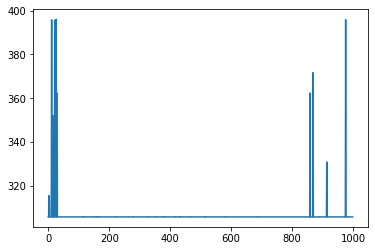

In [511]:
t1 = time.time()
outputs = obj.perform_MCTS(obj.root)
t2 = time.time()
delta = t2 - t1

final = deepcopy(obj.traverse_final(obj.root))
# time difference in seconds
print("seed", seed)
print("final cost", final.get_total_cost())
print(f"Time difference is {delta} seconds")
plt.plot(outputs)

In [512]:
#final = deepcopy(obj.traverse_final(obj.root))
# print("before", final.blocks[0].block_ports[1])
# #final.blocks[0].move_port(1, 1)
# print("after", final.blocks[0].block_ports[1])
# print("overlap value", final.get_overlap_cost())
# print("total value", final.get_total_cost())
# print("state value", final.get_state_value())

# for block in final.blocks:
#     print("block", block.get_block_id())
#     for port, edge, pos in block.block_ports:
#         print(port.get_port_id(), edge, pos)
#         print("edge_length", block.edges[edge])

#print("final cost", final.get_total_cost())

#final.export_port_positions('tests/new_tests/output5.csv')

level1 0  cost 1255.5634918610403
level2 1  cost 305.6719600745604 children 32
level1 1  cost 305.6719600745604
level2 2  cost 305.6719600745604 children 0
final cost 305.6719600745604


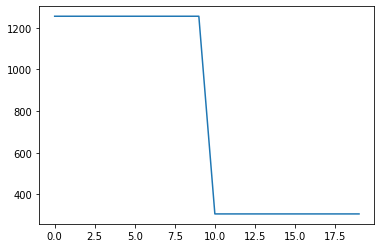

In [513]:
def traverse_final(curr_state):
    level = 0
    result = []
    prev_state = None
    ans_state = None
    ans_cost = 1e18
    while(len(curr_state.children)!=0):
        prev_state = curr_state
        cost = curr_state.get_total_cost()
        print("level1", level, " cost", cost)
        if cost< ans_cost:
            ans_cost=cost
            ans_state = prev_state
        level += 1
        curr_state = curr_state.best_child_traverse()
        print("level2", level, " cost", curr_state.get_total_cost(), "children", len(curr_state.children))
        result.extend([cost]*10)
    plt.plot(result)
    return ans_state

final = deepcopy(traverse_final(obj.root))
print("final cost", final.get_total_cost())
final.export_port_positions('tests/new_tests/output_4X.csv')

In [514]:
print(final.blocks[0].edge_overlap(1))
print(final.blocks[0].total_overlap())
#obj.root.export_port_positions('tests/new_tests/output2.csv')

30.0
30.0


In [515]:
for block in obj.root.blocks:
    print(block.get_block_id())
    #block.print_ports()
    print("edge_overlap before", block.edge_overlap(0))
    block.move_port(0, -1)
    #block.move_port(1, 1)
    print("edge_overlap after", block.edge_overlap(0))
    for port_info in block.block_ports:
        port, edge, pos = port_info
        print(port.get_port_id())
        print(block.get_port_pos(port.get_port_id()))

blockA
edge_overlap before 180.0
edge_overlap after 90.0
portA_1
[30, 0, 0, 10]
portA_2
[0, 0, 10, 30]
portA_3
[0, 0, 10, 30]
portA_4
[0, 0, 10, 30]
blockB
edge_overlap before 180.0
edge_overlap after 90.0
portB_1
[140, 110, 110, 120]
portB_2
[110, 110, 120, 140]
portB_3
[110, 110, 120, 140]
portB_4
[110, 110, 120, 140]
blockC
edge_overlap before 180.0
edge_overlap after 90.0
portC_1
[140, 0, 110, 10]
portC_2
[110, 0, 120, 30]
portC_3
[110, 0, 120, 30]
portC_4
[110, 0, 120, 30]
blockD
edge_overlap before 180.0
edge_overlap after 90.0
portD_1
[30, 110, 0, 120]
portD_2
[0, 110, 10, 140]
portD_3
[0, 110, 10, 140]
portD_4
[0, 110, 10, 140]


In [516]:
def BFS(node):
    queue = []
    queue.append(node)
    depth=1
    while queue:
        print("depth", depth, "total", len(queue))
        depth += 1
#         for ele in queue:
#             print("[", ele.get_state_value(),ele.visits, "] ", end=" ")
#         print("\n")
        
        length = len(queue)
        for ele in range(0,length):
            m = queue.pop(0)
            for node in m.children:
                queue.append(node)

curr_node = obj.root
BFS(curr_node)

depth 1 total 1
depth 2 total 32
depth 3 total 947
depth 4 total 21


In [517]:
# for i in range(96):
#     print(obj.root.children[i].get_total_cost(), obj.root.children[i].visits)
# print("\n",final.get_total_cost())

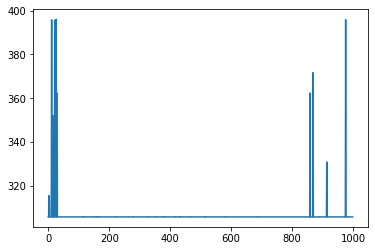

In [518]:
plt.plot(outputs)